In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.svm import SVC

base_path = Path('/content/drive/MyDrive/DANE LEKCJA 1') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

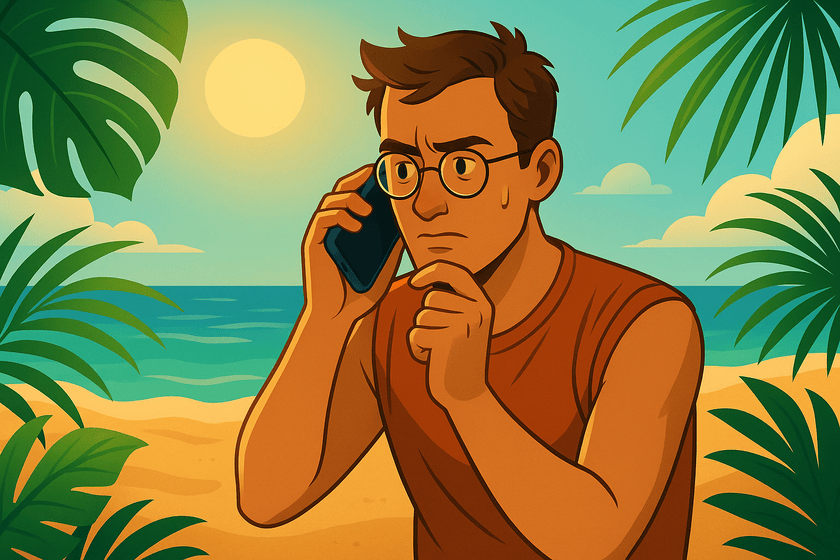

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

# 0. Dane i Wnioski z Zadania 1

**Przenoszę dane tak jak były w zadaniu 1 z poprawkami**

In [4]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

titanic_df['Age'] = titanic_df.groupby(["Pclass", 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
titanic_df['Fare'] = titanic_df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])
ages = np.array(['Children', 'Youth and Adults', 'Elderly people'])
titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=[0, 14, 64, np.inf], labels=ages)
titanic_df['IsAlone'] = titanic_df['SibSp'] + titanic_df['Parch'] == 0
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df = titanic_df.drop(columns=['Name', 'Ticket', 'Cabin'])
titanic_df['AgeGroup'] = titanic_df['AgeGroup'].map({'Children': 0, 'Youth and Adults': 1, 'Elderly people': 2})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,IsAlone
PassengerId,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,2,1,False
2,1,1,1,38.0,1,0,71.2833,0,1,False
3,1,3,1,26.0,0,0,7.9250,2,1,True
4,1,1,1,35.0,1,0,53.1000,2,1,False
5,0,3,0,35.0,0,0,8.0500,2,1,True
...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.0000,2,1,True
888,1,1,1,19.0,0,0,30.0000,2,1,True
889,0,3,1,21.5,1,2,23.4500,2,1,False


Wnioski i obserwacje z zadania 1:

*   Klasa - największe szanse na przeżycie miało się podróżując klasą 1 z 60% szans
na przetrwanie
*   Płeć - kobiety poradziły sobie lepiej i miały przeżywalność na poziomie 70%
*   Grupa Wiekowa - dzieci cieszyły się największą szansą na przeżycie, wówczas gdy osoby starsze miały tylko 10%
*   Port - wejście na pokład w Cherboughu dawało ponad 50% szans





# 1. Podział danych

In [5]:
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dzielimy dane na treningowe i testowe w stosunku 4/5 (**Dane treningowe - 80%**, **Dane testowe - 20%**)

# 2. Dummy Clasifier

In [6]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Dokładność: {accuracy_score(y_test, y_pred) * 100:.2f}')
print(f'Precyzja: {precision_score(y_test, y_pred) * 100:.2f}')
print(f'Wynik F1: {f1_score(y_test, y_pred) * 100:.2f}')

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       105
           1       0.47      0.42      0.44        74

    accuracy                           0.56       179
   macro avg       0.54      0.54      0.54       179
weighted avg       0.56      0.56      0.56       179

Dokładność: 56.42
Precyzja: 46.97
Wynik F1: 44.29


Dokładność Dummy Clasifier wynosi około **50%**, po przeprowadzeniu badania na naszych modelach porównamy ich wyniki z tym

# 3. Decision Tree

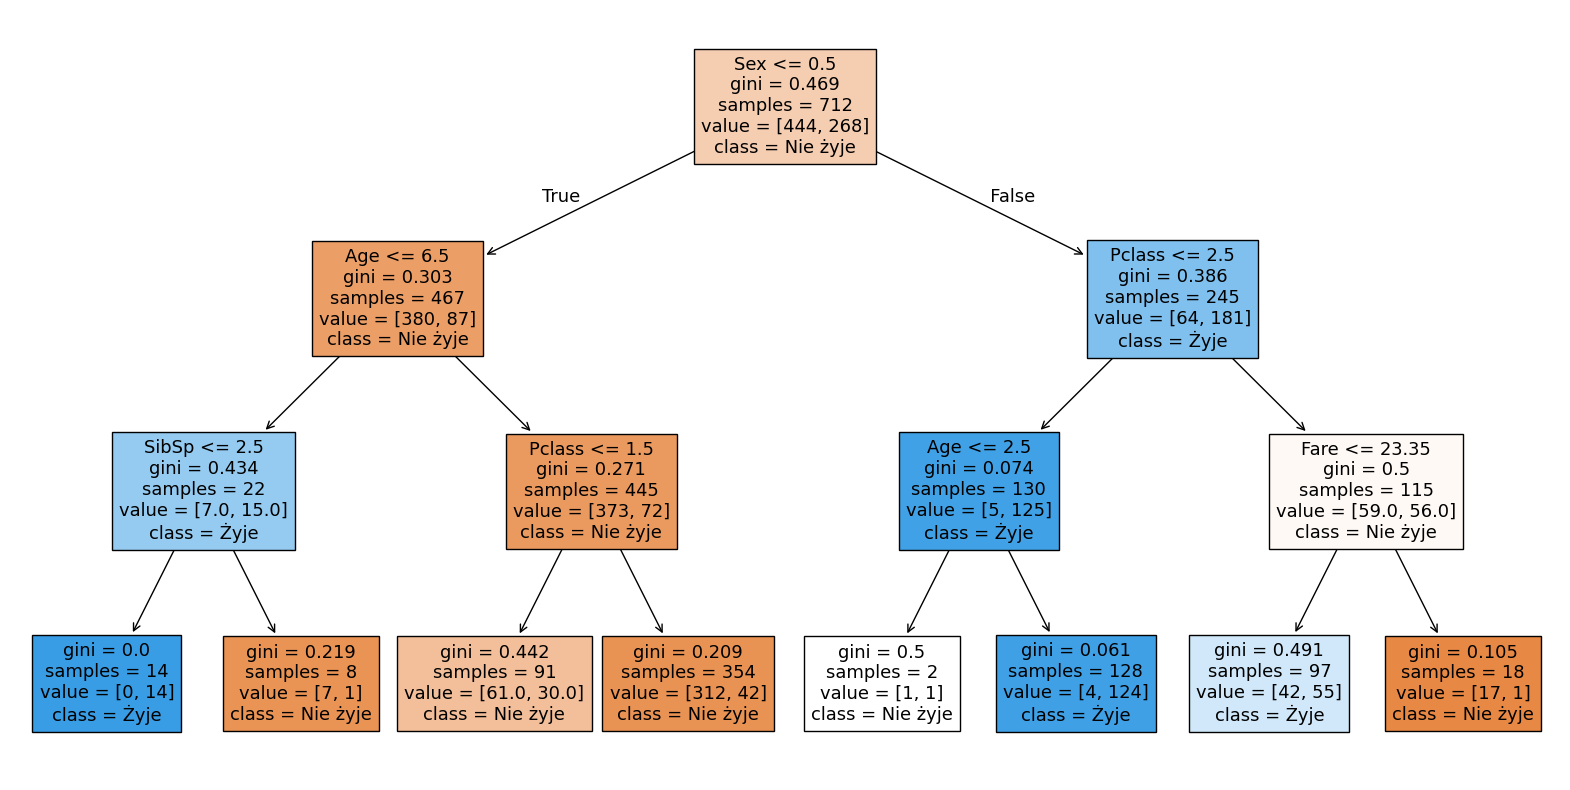

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.78      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

Dokładność: 79.33
Precyzja: 78.46
Wynik F1: 73.38


In [7]:
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
plt.figure(figsize=(20,10))
plot_tree(dt_clf, filled=True, feature_names=X.columns, class_names=['Nie żyje', 'Żyje'])
plt.show()
print(classification_report(y_test, y_pred))
print(f'Dokładność: {accuracy_score(y_test, y_pred) * 100:.2f}')
print(f'Precyzja: {precision_score(y_test, y_pred) * 100:.2f}')
print(f'Wynik F1: {f1_score(y_test, y_pred) * 100:.2f}')

Nasze drzewo decyzyjne ma dokładność na poziomie ok. **80%** więc osiągneliśmy wynik lepszy niż DummyClassifier. Przeanalizujmy teraz jak będzie zmieniał się wynik w zależności od hiperparametrów modelu.

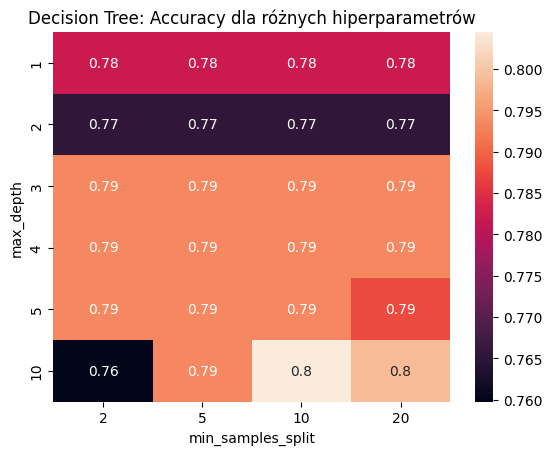

In [8]:
max_depths = [1, 2, 3, 4, 5, 10]
min_samples = [2, 5, 10, 20]

results = []

for d in max_depths:
    row = []
    for s in min_samples:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_split=s, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        row.append(acc)
    results.append(row)

sns.heatmap(np.array(results), annot=True, xticklabels=min_samples, yticklabels=max_depths)
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.title("Decision Tree: Accuracy dla różnych hiperparametrów")
plt.show()

Samo zwiększenie max_depth nie przyniesie nam dobrych skutków i otrzymamy dokładność na poziomie **76%**, najlepsze wyniki otrzymamy dla bardziej rozbudowanych drzewek i będą sięgać aż **80%**.  Dobry wynik także da nam średniej wielkości drzewo.

# 4. SVM


In [9]:
svc_clf = SVC(kernel='rbf', C=1)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'Dokładność: {accuracy_score(y_test, y_pred) * 100:.2f}')
print(f'Precyzja: {precision_score(y_test, y_pred) * 100:.2f}')
print(f'Wynik F1: {f1_score(y_test, y_pred) * 100:.2f}')

              precision    recall  f1-score   support

           0       0.65      0.92      0.76       105
           1       0.73      0.30      0.42        74

    accuracy                           0.66       179
   macro avg       0.69      0.61      0.59       179
weighted avg       0.69      0.66      0.62       179

[[97  8]
 [52 22]]
Dokładność: 66.48
Precyzja: 73.33
Wynik F1: 42.31


Dla kernel='rbf' i C=1 Model SVM osiągnął dokładność na poziomie ok. **65%**, czyli mniej niż drzewo decyzji, pozostałe metryki także wynoszą mniej, największa różnica jest widoczna w F1-score i wynosi nie wiele więcej niż DummyClassifier, sprawdźmy teraz jak będą wyglądały wyniki w zależności od 'kernel'


Największą dokładność nasz model ma dla kernel='linear' i wynosi ok. 80%, zobaczmy jakie wyniki będziemy ]mieli dla różnych wartości C

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]
kernels = ['rbf', 'linear', 'poly']

results = {k: [] for k in kernels}

for k in kernels:
    for c in C_values:
        svc_clf = SVC(kernel=k, C=c)
        svc_clf.fit(X_train, y_train)
        y_pred = svc_clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[k].append(acc)

plt.figure(figsize=(8,5))
for k in kernels:
    plt.plot(C_values, results[k], marker='o', label=k)

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy w zależności od C dla różnych kernelów')
plt.legend()
plt.grid(True)
plt.show()


Widzimy że najwyższą dokładność otrzymujemy dla C=0,01 i kernel='linear' sprawdźmy jak wygląda reszta danych dla takiego zestawienia hiperparametrów. Najsłabiej wypada tutaj ustawienie kernel na 'poly' dla praktycznie każdej wartości ma najmniejszą dokładność a jak już jest lepszy to o ułamki %.

In [ ]:
svc_clf = SVC(kernel='linear', C=0.01)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'Dokładność: {accuracy_score(y_test, y_pred) * 100:.2f}')
print(f'Precyzja: {precision_score(y_test, y_pred) * 100:.2f}')
print(f'Wynik F1: {f1_score(y_test, y_pred) * 100:.2f}')

Otrzymujemy dokładnośc na poziomie +-**80%**, precyzje na poziomie prawie **90%**, więc myśle, że model można uznać za poprawny. Najlepsze wyniki osiągnał model SVM, jednak oba modele są poprawne, ponieważ sprawują się lepiej od DummyClasifier.